In [1]:
#@title Gather Data
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready!"

Unzipping files...
Merging training data...
Cleaning up...
Data ready!


In [2]:
#@title Imports
import pandas as pd
import tensorflow as tf
from tensorflow import keras as ks
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import sklearn
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.applications as app
import seaborn as sns

!pip install coremltools
import coremltools as ct 

%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

seed = 42
training_dir = '/content/training/'
test_dir = '/content'
checkpoint_filepath = '/content/checkpoint3'
# init_weights_path = '/content/checkpoint2'
new_weights_path = '/content/model_weights'
image_size = (100, 100, 3)
num_classes = 43

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.1 MB/s eta 0:00:00


In [3]:
#@title Train/Test Split
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits

train_datagen = ImageDataGenerator(
        rescale=1/255,
        validation_split=.2,
        rotation_range=10,          # Hard: 10, easy: 4
        width_shift_range=0.25,     # Hard: .22, easy: .1
        height_shift_range=0.25,    # Hard: .22, easy: .1
        brightness_range=(.6, 1.5), # Hard: (.6, 1.5), easy: (.8, 1.2)
        shear_range=25,             # Hard: 22, easy: 10
        zoom_range=0.5,             # Hard: .4, easy: .15
)
# *Don't* do preprocessing on the validation set
validation_datagen = ImageDataGenerator(
        rescale=1/255,
        validation_split=.2, 
)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=image_size[:2],
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=seed, 
        shuffle=True
)
val_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size[:2],
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=seed,
        shuffle=False
)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


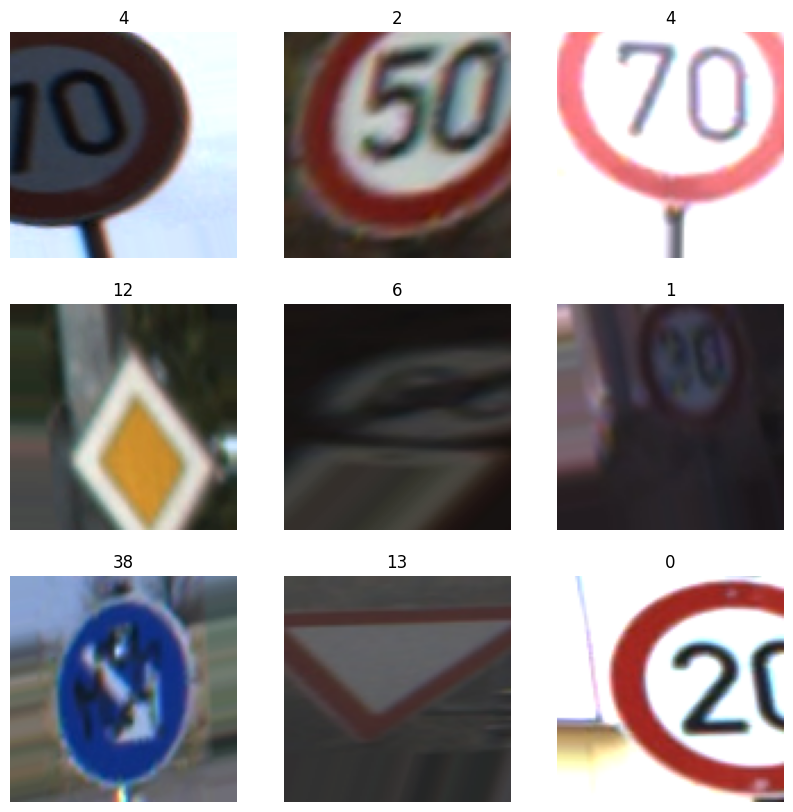

In [4]:
#@title
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

# Models

In [5]:
loss = "sparse_categorical_crossentropy"

In [6]:
#@title Custom Model
custom = ks.Sequential([
    layers.Conv2D(32, (3,3), input_shape=image_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.15),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(.2),
    layers.Dense(num_classes, activation='softmax'),
])
custom.compile(optimizer=ks.optimizers.Adam(learning_rate=.000115), loss=loss, metrics=['accuracy', loss])
custom.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [7]:
#@title Premade Model
premade = app.vgg16.VGG16(
    # whether to include the fully-connected layer at the top of the network. (I don't know what this means)
    include_top=True,
    # The pretrained weights
    weights=None,
    # input_tensor=None,
    input_shape=image_size,
    # Only applies when include_top is False
    # pooling=None,
    # optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.
    classes=num_classes,
)
premade.compile(optimizer=ks.optimizers.Adam(learning_rate=.0001), loss=loss, metrics=['accuracy', loss])
premade.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [8]:
model = premade

In [10]:
#@title Load Weights
if True:
    file = '/content/savedModel/premade_weights.h5'
    file = '/content/premade_weights.h5'
    # ks.models.load_model(file)
    model.load_weights(file)

FileNotFoundError: ignored

In [ ]:
#@title Training
checkpoint_callback = ks.callbacks.ModelCheckpoint(checkpoint_filepath, save_best_only=True, mode='max', monitor='val_'+loss, save_weights_only=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = ks.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# This is going to run for `epochs` epochs, and at each epoch, it's going to train on `steps_per_epoch` batches of `batch_size` images (defined in the split section)
# Depending on our parameters, this will potentially *not* run through all the images, it'll train on epochs * steps_per_epoch * batch_size number of [preprocessed] images
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=1,
    validation_data=val_generator,
    validation_steps=50,
    callbacks=[checkpoint_callback, tensorboard_callback], 
    initial_epoch=0
)

In [ ]:
#@title Saving the model
# I LOST MY CHECKPOINT ONCE, NEVER AGAIN
name = 'custom' if model == custom else 'premade'

# Make everything save in a specific directory
!mkdir /content/savedModel/
%cd /content/savedModel/

# Save in every format we can think of
model.save_weights(name  + '_weights')
model.save_weights(name + '_weights.h5')

model.save(name + '_whole')

# mlmodel = ct.convert(model)
mlmodel = ct.convert(model, convert_to="mlprogram")
mlmodel.save(name + "_modelProgram.mlpackage")
# mlmodel = ct.convert(model)
# mlmodel.save(name + "_model.mlpackage")
%cd /content
# To save on RAM? It keeps crashing when I run this repeatedly
del mlmodel

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
#@title Testing
partial = False
answers = pd.read_csv('test_classes_partial.csv')

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test' + ('_partial' if partial else '')],
        target_size=image_size[:2],
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator, use_multiprocessing=True)

if partial:
    answers['predictions'] = [np.argmax(probas) for probas in probabilities]
    display(answers)
else:
    holdoutPred = [np.argmax(probas) for probas in probabilities]
    pd.DataFrame({'predictions': holdoutPred}).to_csv('holdout_predictions.csv')

In [ ]:
#@title Evaluation
sns.set(rc={'figure.figsize':(20,20)})
ConfusionMatrixDisplay.from_predictions(answers.ClassId, answers.predictions, cmap='Blues')
print(f'accuracy_score:', sklearn.metrics.accuracy_score(answers.ClassId, answers.predictions))
print(classification_report(answers.ClassId, answers.predictions, labels=None))

# Notes
- WE're *awesome*
- 